In [1]:
import math
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
import sympy as sp

from scipy.signal import argrelextrema
import glob
import csv
import pandas as pd

import os
from os.path import join as pj
import shutil

from IPython.display import Image
from IPython.display import display

import PIL
import pickle

import plotly.express as px
import plotly.graph_objects as go

In [2]:
# For debugging purposes
from IPython import get_ipython
def in_notebook():
    ip = get_ipython()
    
    if ip:
        return True
    else:
        return False

In [3]:
_HOME_DIR = os.path.expanduser("~")
if in_notebook():
    _SPARCFIRE_DIR = pj(_HOME_DIR, "sparcfire_matt") 
    _MODULE_DIR    = pj(_SPARCFIRE_DIR, "GalfitModule")
    #_MODULE_DIR="/home/azraz/SpArcFiRe/GalfitModule"
else:
    try:
        _SPARCFIRE_DIR = os.environ["SPARCFIRE_HOME"]
        _MODULE_DIR = pj(_SPARCFIRE_DIR, "GalfitModule")
    except KeyError:
        print("SPARCFIRE_HOME is not set. Please run 'setup.bash' inside SpArcFiRe directory if not done so already.")
        print("Running on the assumption that GalfitModule is in your home directory... (if not this will fail and quit!)") 
        _MODULE_DIR = pj(_HOME_DIR, "GalfitModule")
    
sys.path.append(_MODULE_DIR)

from Classes.Components import *
from Classes.Containers import *
from Classes.FitsHandlers import *
from Functions.helper_functions import *
from sparc_to_galfit_feedme_gen import arc_information, galaxy_information

In [4]:
#DIFFERENTIAL APPROACH

In [5]:
def pitch_angle(*args):
    CDEF = 0.23
    
    #args = [float(arg) for arg in args]
    r = args[0]
    theta_out = args[1]
    r_out = args[2]
    alpha = args[3]
    r_in = np.zeros(np.shape(r))
    if len(args) == 5:
        r_in = args[4]
    
    theta_out = np.radians(theta_out) #+ sky_pa)

    A = 2*CDEF/(np.abs(theta_out) + CDEF) - 1.00001
    B = (2 - np.arctanh(A))*(r_out/(r_out - r_in))
    C = 2 - B
    #D = theta_out * 0.5**alpha
    inv_r_out = 1/r_out

    p1 = 0.5*(np.tanh(B*(inv_r_out*r - 1) + 2) + 1)
    p2 = theta_out*np.power(0.5*(inv_r_out*r + 1), alpha)

    theta_r = p1*p2
    
    plt.scatter(r, np.degrees(theta_out*p1), color = "red")
    plt.scatter(r, np.degrees(p2), color = "blue")
    plt.scatter(r, np.degrees(theta_r), color = "green")

    #print(C + B*r/r_out)
    try:
        #denom = 2*r_out*(np.cosh(C + B*r/r_out))**2
        sech = 1/np.cosh(C + B*r*inv_r_out)
        #denom = 2*r_out*sech**2
    except OverflowError:
        return None, None
    
    dp1 = B*sech**2/(2*r_out)

    # denom = r_out + r
    denom = (2*r_out)**alpha*(r_out + r)
    # dp2 = alpha*(D/denom)*(1 + r/r_out)**alpha
    dp2 = alpha*theta_out*(r + r_out)**alpha/denom
    #dp2 = 0.5**alpha * alpha * theta_out * ((r_out + r)/r_out)**alpha / (r_out + r)

    dtheta_dr = dp1*p2 + dp2*p1
    #k = dtheta_dr*2

    pa = np.degrees(np.arctan2(1, np.abs(r*dtheta_dr)))
  
    return pa, theta_r#, dtheta_dr

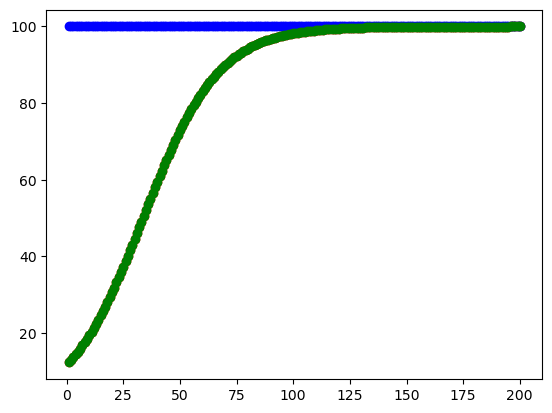

In [6]:
r = np.linspace(1,200,200)
r_out = 100
theta_out = 100
alpha = 0
r_in = 0
_ , theta_r = pitch_angle(r, theta_out, r_out, alpha, r_in)
#plt.scatter(r,  np.abs(np.degrees(theta_r)))

In [7]:
def spiral_eq():
    
    r, t, _r_in, _r_out, _theta_out, _alpha, _CDEF = sp.symbols('r t _r_in _r_out _theta_out _alpha _CDEF', real = True)
    
    A = 2*_CDEF/(_theta_out + _CDEF) - 1.00001
    B = (2 - sp.atanh(A))*(_r_out/(_r_out - _r_in))

    theta_eq = 2*t/_theta_out - 1

    tanh_eq = sp.tanh(B*(r/_r_out - 1) + 2)
    powerlaw_eq = 0.5*(r/_r_out + 1)**_alpha
    rhs = tanh_eq*powerlaw_eq
    
    series_approx = rhs.series(r, 0, 4).removeO()
    
    full_expr = sp.Eq(theta_eq, series_approx)
    #print(full_expr)
    #root = float(list(sp.solveset(series_approx, r))[0])#, domain=sp.S.Reals))[0])
    #print(root)
    #cond = rvals < root
    #cond2 = rvals >= root
    #theta_r = np.append(theta_r[cond], -theta_r[cond2])
    #rvals = np.append(rvals[cond], -rvals[cond2])
    # Take only real
    #temp = sp.solveset(full_expr, r)
    return full_expr

In [7]:
# # TODO: determine how r varies with theta and use analytical derivative to solve tan(phi) = (dr/dtheta)/r
# # Where phi is pitch angle
def pitch_angle3(*args):
    CDEF = 0.23
    
    #args = [float(arg) for arg in args]
    rvals = args[0]
    theta_out = args[1]
    r_out = args[2]
    alpha = args[3]
    r_in = 0
    if len(args) == 5:
        r_in = args[4]
    
    theta_out = np.radians(theta_out) #+ sky_pa)

    A = 2*CDEF/(abs(theta_out) + CDEF) - 1.00001
    B = (2 - np.arctanh(A))*(r_out/(r_out - r_in))
    inv_r_out = 1/r_out
    #C = 2 - B
    #D = theta_out * 0.5**alpha
    
    p1 = 0.5*(np.tanh(B*(inv_r_out*rvals - 1) + 2) + 1)
    p2 = theta_out*np.power(0.5*(rvals*inv_r_out + 1), alpha)

    theta_r = p1*p2
       
    p1 = 2*p1
    p2 = p2/theta_out
    
    sech = 1/np.cosh(B*rvals*inv_r_out - B + 2)
    
    dtheta = 2/theta_out #2**(1/alpha + 1)*(theta_r/theta_out)**(1/alpha)/(alpha*theta_r)
    dp1_dtheta = B*inv_r_out*sech**2
    num = alpha*(inv_r_out*(r_out + rvals))**alpha
    denom = 2**alpha * (r_out + rvals)
    dp2_dtheta = num/denom
    
    dr_dtheta = dtheta/(p1*dp2_dtheta + p2*dp1_dtheta)
    
    pa = np.degrees(np.arctan2(dr_dtheta, rvals))
  
    return pa, theta_r #, dr_dtheta

In [23]:
def sum_fourier_modes(fourier_dict, **kwargs):
    
    very_small = 0.0000001
    #r0 = kwargs.get("r0")
    #amplitudes = kwargs.get("amplitudes")
    #n = kwargs.get("n")
    #phis = kwargs.get("phis")
    
    #assert len(amplitudes) == len(phis), "Not enough amplitude or phi values passed to fourier mode sum function."
    
    if "theta" in kwargs:
        theta = np.radians(kwargs.get("theta"))
    else:
        xgrid = kwargs.get("xgrid")#, np.linspace(0, 100, 100))
        ygrid = kwargs.get("ygrid")#, np.linspace(0, 100, 100))
        
        x0 = kwargs.get("x0")
        y0 = kwargs.get("y0")
        
        q = kwargs.get("q")
        theta = np.arctan2(ygrid - y0, very_small + q*(xgrid - x0))
        
    fsum = np.zeros(np.shape(theta))
    
    rotate = 1
    for Fstr, Fmode in fourier_dict.items():
        if Fstr == "skip":
            continue
        
        amplitude = Fmode.amplitude
        phi       = Fmode.phase_angle
        
        m = float(Fstr[-1])
        
        if m % 2 == 1 and rotate:
            theta += 0.5*np.pi
            rotate = False
            
        phi = np.radians(phi)
        print(f"Mode: {m}, amp: {amplitude}, angle: {phi}")
        
        fsum += amplitude*np.cos(m*(theta + phi))
    
    rgrid = 1 + fsum #np.sum(np.array(fsum), axis = 0)
    return rgrid, theta

#     fsum = np.array([
#                      amplitude*np.cos(
#                          float(m[-1])*(theta + np.radians(phi)))
#                          for m, (amplitude, phi) in fourier_dict.items()
#                    ])
            
#     rgrid = 1 + np.sum(fsum, axis = 0)
#     return rgrid, theta

In [24]:
grid_pts = 100
xgrid = np.linspace(-1, 1, grid_pts)
ygrid = np.linspace(-1, 1, grid_pts)
#xx = xgrid
#yy = ygrid
xx, yy = np.meshgrid(xgrid, ygrid)

x0 = 0
y0 = 0

#theta = np.linspace(0, 2*np.pi, grid_pts)
q = 1
rgrid = np.sqrt((xx - x0)**2 + ((yy - y0) / q)**2)
plt.clf()
#plt.contour(xx, yy, rgrid, colors = "red")
#rgrid = 1*np.ones(grid_pts)

#rr, tt = np.meshgrid(rgrid, theta)

#print(np.shape(rgrid))

#plt.contour(rgrid, colors = "red")#, ygrid)

#fsum3 = rgrid*sum_fourier_modes({"F3" : (0.05, 0)}, q = q, xgrid = xx, ygrid = yy) #, "F3" : (0.01, 45)})
#fsum3 = rgrid*sum_fourier_modes({"F3" : (0.5, 0)}, q = q, theta = theta) #, "F3" : (0.01, 45)})
fdict = {"F5" : (0.05, 0.0), "F6" : (0.05, 0.0)}
fsum, theta = sum_fourier_modes(fdict, q = q, xgrid = xx, ygrid = yy, x0 = x0, y0 = y0) #, "F3" : (0.01, 45)})
fsum *= rgrid

#print(np.array_str(fsum, precision=2))

#xgrid_r = fsum*np.cos(theta)
#ygrid_r = fsum*np.sin(theta)
#plt.clf()
#plt.plot(xgrid_r, ygrid_r)
plt.contour(xx, yy, fsum, colors = "blue")

# fig = go.Figure(data =
#     go.Contour(
#         z = fsum,
#         contours_coloring='lines'
#     ))
# fig.show()

#xgrid_r = rgrid*np.cos(theta)
#ygrid_r = rgrid*np.sin(theta)
#plt.plot(xgrid_r, ygrid_r)

# xgrid_r = rr*np.cos(tt)
# ygrid_r = rr*np.sin(tt)
# plt.plot(np.diag(xgrid_r), np.diag(ygrid_r))
# #print(fsum3 - rgrid) 
#plt.contour(xx, yy, fsum3, colors = "blue")
#plt.plot(rgrid*np.cos(theta), rgrid*np.sin(theta))
#plt.imshow(fsum5, cmap = "gray")#, fsum3)

#xgrid_r = fsum5*np.cos(theta)
#ygrid_r = fsum5*np.sin(theta)
#plt.contour(xx, yy, fsum5, colors = "red")
#plt.plot(xgrid_r, ygrid_r, fsum5)

AttributeError: 'tuple' object has no attribute 'amplitude'

<Figure size 640x480 with 0 Axes>

In [25]:
grid_pts = 10
xgrid = np.linspace(-10, 10, grid_pts)
ygrid = np.linspace(-10, 10, grid_pts)
xx, yy = np.meshgrid(xgrid, ygrid)

In [26]:
def curvature_ellipse(**kwargs):
    very_small = 0.0000001
    
    xgrid = kwargs.get("xgrid")
    ygrid = kwargs.get("ygrid")

    x0 = kwargs.get("x0") 
    y0 = kwargs.get("y0") 

    q = kwargs.get("q") # b / a
    
    r = np.sqrt( np.abs(xgrid - x0)**2 + np.abs( (ygrid - y0)/q )**2 )
       
#     dr_dx = np.gradient(r, xgrid)
#     d2r_dx2 = np.gradient(dr_dx, xgrid)
    
#     dr_dy = np.gradient(r, ygrid)
#     d2r_dy2 = np.gradient(dr_dy, ygrid)
    
    theta = np.arctan2(ygrid - yc, very_small + q*xgrid - q*xc)
    # numer = (dr_dx**2 + dr_dy**2)**(3/2)
    # denom = dr_dx*d2r_dy2 - dr_dy*d2r_dx2 + very_small
    
    #R = np.abs(numer/denom)
    
    e2 = 1 - q**2
    
    coeff = 1/q
    numer = 1 - e2*(2 - e2) * (np.cos(theta))**2
    denom = 1 - e2*(np.cos(theta))**2
    R_theta = coeff*(numer/denom)**(3/2)
    return R_theta

In [27]:
# grid_pts = 10
# xgrid = np.linspace(-10, 10, grid_pts)
# ygrid = np.linspace(-10, 10, grid_pts)
# xx, yy = np.meshgrid(xgrid, ygrid)

# r = curvature_ellipse(
#     xgrid = xx,
#     ygrid = yy,
#     xc    = 0,
#     yc    = 0,
#     q     = 0.5
# )

# print(r)
# print()
# # theta = np.arctan(xx/yy)
# # r2    = np.sqrt(xx**2 + yy**2)
# # print(theta)
# # print(r2)
# # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# # ax.plot(theta, r)

In [28]:
def modify_grid(x_grid,
                y_grid,
                amplitudes,
                phis,
                q
               ):
    
    #xmatrix, ymatrix = np.meshgrid(xgrid, ygrid)

    # Assume perfect centering
    rgrid = sum_fourier_modes(amplitudes = amplitudes,
                             phis  = phis,
                             xc    = x_max//2,
                             yc    = y_max//2,
                             q     = q,
                             xgrid = xgrid,
                             ygrid = ygrid
                            )
    
    return rgrid

In [29]:
# print(np.shape(modify_grid(0.5,
#                 0.5,
#                 10, 
#                 10,
#                 [0.1],
#                 [30],
#                 0.5,
#                 grid_pts = 100)))

In [30]:
in_dir = "/home/portmanm/testing_python_control/sparcfire-in"
#out_dir = "/home/portmanm/run10_testing_1000/sparcfire-out"
#out_dir = "/home/portmanm/run11_sparcfire_pa/sparcfire-out"
out_dir = "/home/portmanm/testing_python_control/sparcfire-out"
scatter_dir = pj(out_dir, "scatter_plots")
validation_dir = pj(out_dir, "validation_plots")

In [31]:
pd.read_pickle("/home/portmanm/sparcfire_matt/GalfitModule/RegTest/TestOutput/test-out/RegTest_2-step_output_results.pkl")

,magnitude_sersic_1,effective_radius_sersic_1,sersic_index_sersic_1,axis_ratio_sersic_1,position_angle_sersic_1,position_x_sersic_1,position_y_sersic_1,skip_sersic_1,magnitude_sersic_2,effective_radius_sersic_2,...,outer_rad_power_2,cumul_rot_power_2,powerlaw_index_power_2,inclination_power_2,sky_position_angle_power_2,F1_amplitude_fourier_2,F1_phase_angle_fourier_2,F3_amplitude_fourier_2,F3_phase_angle_fourier_2,skip_fourier_2
gname,,,,,,,,,,,,,,,,,,,,,
1237655463239155886,18.843599,34.004902,1.4581,0.0374,-68.132599,30.000000,30.000000,0.0,11.6317,28.012300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1237667735062577326,13.217900,16.578199,1.5581,0.8920,37.990700,87.860001,87.389999,0.0,15.2474,16.504299,...,9.3700,-96.167000,1.1104,-34.766602,-161.748505,0.0486,133.530106,0.1557,7.482500,0.0
1237667735565238388,17.468700,2.283700,0.0212,0.3898,-50.467098,47.509998,47.160000,0.0,13.4807,9.662100,...,5.8504,75.247002,1.1906,-27.389500,12.776500,-0.0807,-71.467697,0.0051,15.054100,0.0
1237667911674233053,14.095600,11.066500,0.4676,0.7634,48.895599,55.910000,55.750000,0.0,13.9026,10.774800,...,5.9512,-115.279099,0.8703,35.252998,136.422806,0.1000,-161.266205,0.0723,32.354900,0.0
1237667911674691747,14.518400,8.159200,0.3703,0.6592,-42.429600,33.169998,32.880001,0.0,13.7559,4.798600,...,2.4184,-3441.877930,0.0150,-12.704000,35.577000,0.1223,120.639297,0.0822,15.562500,0.0
1237667912741355660,16.333799,2.741800,0.6503,0.7603,74.762100,48.939999,49.630001,0.0,13.9809,9.520100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1237668310013640891,13.675300,15.617200,0.5577,0.6430,-20.893999,77.699997,77.150002,0.0,14.1025,16.203400,...,7.9099,101.736603,1.2703,-0.041700,148.522995,0.1134,-80.925903,0.0925,-31.488300,0.0
1237668311090200859,14.314300,0.003500,9.9855,0.0329,-47.223099,61.029999,60.660000,0.0,13.3770,13.366100,...,7.7113,-51.526901,1.2044,-54.017101,135.642197,-0.0648,114.702202,0.0251,-28.562901,0.0
1237668589728366770,13.848200,9.072900,0.3176,0.7727,77.019699,43.439999,43.799999,0.0,13.7025,7.754600,...,3.9079,-66.111099,1.1993,-32.587002,163.332596,-0.1000,-60.990799,0.0638,6.024500,0.0


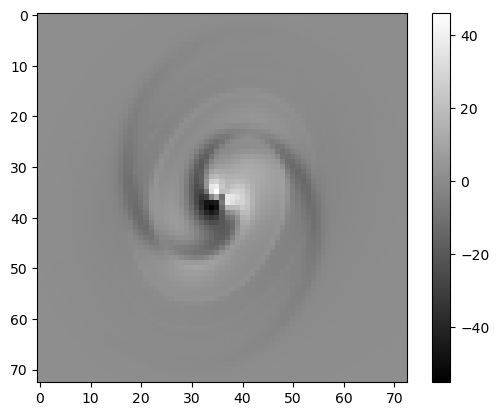

In [32]:
gname = "1237648721232855215"
with fits.open(pj(out_dir, gname, f"{gname}_galfit_out.fits")) as wf:
    with_fourier = wf[2].data
    
with fits.open(pj(out_dir, gname, f"no-fourier.fits")) as wf:
    without_fourier = wf[2].data
    
combined = with_fourier - without_fourier
plt.imshow(combined, cmap='gray')
plt.colorbar()

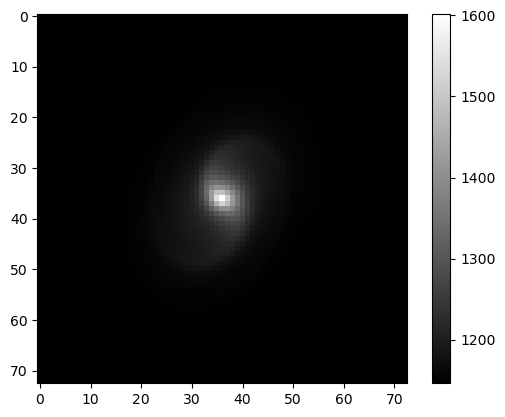

In [33]:
plt.imshow(with_fourier, cmap='gray')
plt.colorbar()

1237648721232855215 ok
Fourier transforming...
Mode: 1.0, amp: 0.2124, angle: 1.7398838247281072
Mode: 3.0, amp: -0.0361, angle: -0.9048205721359083


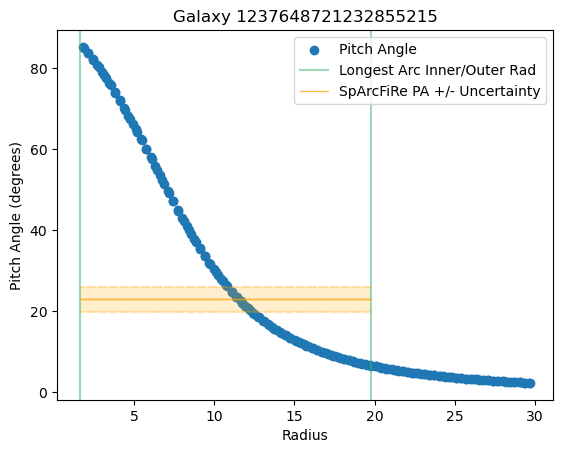

Difference in pitch angle measures (between tangents and differential) at radius 15: 0.16


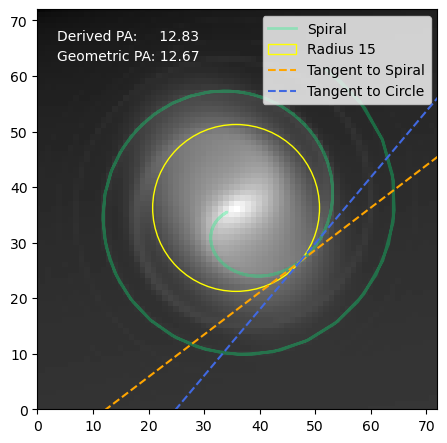

In [48]:
#(r=10, theta_out=0, r_out=0, alpha=0)

#good_fits = {gpath : None for gpath in }
bad_fits = dict()
polar_coordinates = dict()
diff_pa = dict()
diff2_pa = dict()
data = []

count = 0
out_dir = "/home/portmanm/testing_python_control/sparcfire-out"
for gpath in glob.glob(pj(out_dir, "123*")):
    
    if count < 50:
        #count += 1
        gname = os.path.basename(gpath)
        #if gname not in ("1237648721232855215", "1237662224625369287", "1237648705669103794"):
        #if gname not in ("1237665227305451703"):
        #if gname not in ("1237648704595624148"):
        #if gname not in ("1237648705669103794"):
        if gname not in ("1237648721232855215"):
        #if gname not in ("1237667541750775937"):
            continue
        try:
            #print('enter try')
            fits_file = OutputFits(pj(gpath, f"{gname}_galfit_out.fits"))
            #fits_file = FitsFile(pj(gpath, f"{gname}_galfit_out-no_incl.fits"))
            #fits_file = OutputFits(pj(gpath, "no-fourier.fits"))
            #fits_file = OutputFits(pj(gpath, "no-incline.fits"))
            #fits_file = OutputFits(pj(gpath, "no-nothin.fits"))
            print(gname, 'ok')
        except (AttributeError, FileNotFoundError, Exception) as e:
            print(e)
            #print('enter catch')
            continue

        feedme = FeedmeContainer()
        feedme.from_file(fits_file.header)
        
        fit_region = feedme.header.region_to_fit.value

        disk   = feedme.disk
        center = disk.position.value
        q      = disk.axis_ratio.value

        arms       = feedme.arms
        incl       = np.cos(np.radians(arms.inclination.value))
        
        fourier    = feedme.fourier

        #amplitudes = [k[-1] : v[0] for k,v in fourier.param_values.items() if k != "skip"] #fourier.amplitudes 
        #phis       = [v[1] for k,v in fourier.param_values.items() if k != "skip"] #fourier.phase_angles
        
        #amplitudes = [0, 0]
        #phis       = [0, 0]
        
        x_box_len = fit_region[1] - fit_region[0]
        y_box_len = fit_region[3] - fit_region[2]
        xmin = 0.01
        ymin = 0.01
        xmax = x_box_len #outer_rad*np.cos(arms.cumul_rot)
        ymax = y_box_len #outer_rad*np.sin(arms.cumul_rot)
        
#         xmin = fit_region[0] - x_box_len
#         xmax = fit_region[1] - x_box_len
        
#         ymin = fit_region[2] - y_box_len
#         ymax = fit_region[3] - y_box_len
        
        num_pts = 500
        #rvals_grid  = np.linspace(xmin, 0.5*xmax, num_pts)
        xgrid = np.linspace(xmin, xmax, num_pts)
        x0 = center[0] - fit_region[0] #0.5*xmax
        ygrid = np.linspace(ymin, ymax, num_pts)
        y0 = center[1] - fit_region[2] #0.5*ymax
        
        #xx, yy = np.meshgrid(xgrid, ygrid)
        xx = xgrid
        yy = ygrid
        rvals_grid = np.sqrt((xx - x0)**2 + ((yy - y0)/q)**2)
        
        # rvals_grid = curvature_ellipse(
        #                  xc    = xmax//2,
        #                  yc    = ymax//2,
        #                  q     = q,
        #                  xgrid = xgrid,
        #                  ygrid = ygrid
        #                 )

        #galaxy_dict = galaxy_information(gname, pj(out_dir, gname))
        galaxy_info = pd.read_csv(pj(out_dir, gname, f"{gname}.csv"))
        crop_rad = float(galaxy_info[" cropRad"].iloc[0])
        scale_fact_std = 2*crop_rad/256
        #num_arms = 1

        # Set num_arms to 1 to just grab info from the longest arc
        # arc_info = arc_information(
        #                            gname, 
        #                            pj(out_dir, gname), 
        #                            num_arms = num_arms, #galaxy_dict["est_arcs"], 
        #                            bulge_rad = 1000, #galaxy_dict["bulge_maj_axs_len"], 
        #                            scale_fact_std = scale_fact_std
        #                           )
        try:
            arc_info = pd.read_csv(pj(out_dir, gname, f"{gname}_arcs.csv"))
            inner_rad = scale_fact_std*min(arc_info.loc[0, "r_start"], arc_info.loc[1, "r_start"])
            outer_rad = scale_fact_std*max(arc_info.loc[0, "r_end"], arc_info.loc[1, "r_end"])
        except:
            print("Not OK")
            continue
        
#         inner_idx = np.argmin(np.abs(rvals_grid - inner_rad))
#         outer_idx = np.argmin(np.abs(rvals_grid - outer_rad)) + 1
        
#         if outer_idx >= len(rvals_grid):
#             outer_idx = len(rvals_grid) - 1

#         old_inner = rvals_grid[:inner_idx]
#         old_outer = rvals_grid[outer_idx:]

        # Basic dynamic grid, get higher resolution between inner and outer arm radius according to sparcfire
#         high_res_xgrid = np.linspace(xgrid[inner_idx], xgrid[outer_idx - 1], num_pts)
#         high_res_ygrid = np.linspace(ygrid[inner_idx], ygrid[outer_idx - 1], num_pts)
#         high_res_rgrid = np.linspace(rvals_grid[inner_idx], rvals_grid[outer_idx - 1], num_pts)

#         xgrid      = np.concatenate([old_inner, high_res_xgrid, old_outer])
#         ygrid      = np.concatenate([old_inner, high_res_ygrid, old_outer])
#         rvals_grid = np.concatenate([old_inner, high_res_rgrid, old_outer])
        
#         num_pts = len(rvals_grid)

    #        rvals_grid = np.meshgrid(rvals_full)
        rvals_grid = np.sqrt((xx - x0)**2 + ((yy - y0)/q)**2)
    
        #inner_rad = 0
        #outer_rad = np.sqrt(xmax**2 + ymax**2)
        cond    = (rvals_grid > inner_rad) & (rvals_grid <= outer_rad)
        #xx = np.linspace(xgrid[cond][0], xgrid[cond][-1], num_pts)
        #yy = np.linspace(ygrid[cond][0], ygrid[cond][-1], num_pts)       
        
        rvals_grid = np.sqrt((xx - x0)**2 + ((yy - y0)/q)**2)
        # ones = np.ones(np.shape(rvals_grid))
        # _, thetas = pitch_angle(
        #     rvals_grid, 
        #     ones*arms.cumul_rot,
        #     ones*arms.outer_rad, 
        #     ones*arms.powerlaw, 
        #     ones*arms.inner_rad
        # )

        
        if fourier.parameters["skip"]:
            # Without Fourier 
            rgrid = deepcopy(rvals_grid)
            print("No Fourier transform applied.")
        else:
            # With Fourier 
            print("Fourier transforming...")
            fsum, theta = sum_fourier_modes(
                                    fourier.parameters,
                                    #amplitudes = amplitudes,
                                    #phis  = phis,
                                    x0    = x0,
                                    y0    = y0,
                                    q     = q,
                                    xgrid = xx,
                                    ygrid = yy
            )
            rgrid = rvals_grid*fsum
                
        inner_idx = np.argmin(np.abs(rgrid - inner_rad))
        outer_idx = np.argmin(np.abs(rgrid - outer_rad))# + 1
        
        #rgrid = rgrid[cond]
        
        ones = np.ones(np.shape(rgrid))
        #with_fourier = np.array(list(map(pitch_angle, rgrid_mesh, ones*arms.cumul_rot, ones*arms.outer_rad, ones*arms.powerlaw)))
        pitch_angles, thetas = pitch_angle(
            rgrid, 
            ones*arms.cumul_rot.value,
            ones*arms.outer_rad.value, 
            ones*arms.powerlaw_index.value, 
            ones*arms.inner_rad.value
        )
        #plt.scatter(rgrid, 360 - np.degrees(thetas) % 360)
        #break
        
        #with_fourier = pitch_angle3(rgrid, ones*arms.cumul_rot, ones*arms.outer_rad, ones*arms.powerlaw)
        #print(with_fourier)
        
        #pitch_angles = np.abs(pitch_angles)
        # fig = plt.gcf()
        # ax_polar = fig.add_axes(axes_coords, projection = 'polar', frameon = False)
        # ax_polar.plot(thetas, rgrid)
        # fig.show()
        # cond         = rgrid <= xmax
        # rgrid        = rgrid[cond]
        # pitch_angles = pitch_angles[cond]
        # thetas       = thetas[cond]
        # xgrid        = xgrid[cond]
        # ygrid        = ygrid[cond]
        # ones         = ones[cond]
                
        plt.clf()
        #plt.contour(xx, yy, rvals_grid, label='_nolegend_', colors = "red")
        #plt.contour(xx, yy, rgrid, label='_nolegend_', colors = "blue")
        
#         thetas_rot = thetas - np.radians(arms.sky_position_angle) - np.radians(disk.position_angle) + 0.5*np.pi # + np.radians(15)
#         rgrid_incl = rgrid*np.cos(np.radians(arms.inclination))
        
#         x_vals = rgrid_incl*np.cos(thetas_rot) + x0
#         y_vals = rgrid_incl*np.sin(thetas_rot) + y0
#         plt.plot(np.diag(x_vals), np.diag(y_vals), color='springgreen', alpha=0.3,  linewidth=2)
        
#         pitch_angles, thetas = pitch_angle(rvals_grid, ones*arms.cumul_rot, ones*arms.outer_rad, ones*arms.powerlaw, ones*arms.inner_rad)
        
#         thetas_rot = thetas - np.radians(arms.sky_position_angle) - np.radians(disk.position_angle) + 0.5*np.pi # + np.radians(15)
#         rgrid_incl = rgrid*np.cos(np.radians(arms.inclination))
        
#         x_vals = rgrid_incl*np.cos(thetas_rot) + x0
#         y_vals = rgrid_incl*np.sin(thetas_rot) + y0
         
        
#         break
#         plt.axvline(x = rgrid[inner_idx], color = 'mediumseagreen', alpha = 0.5)
#         plt.axvline(x = rgrid[outer_idx], color = 'mediumseagreen', alpha = 0.5, label='_nolegend_')
        
        cond = (rgrid >= inner_rad) & (rgrid <= 1.5*outer_rad)
        
        limited_rgrid = rgrid[cond]
        limited_thetas = thetas[cond]
        limited_pitch_angles = pitch_angles[cond]
        limited_thetas_rot = limited_thetas + np.radians(arms.sky_position_angle.value) + 0.5*np.pi + np.radians(disk.position_angle.value)
        
        x_vals = limited_rgrid*np.cos(limited_thetas_rot) + x0# + arms.outer_rad
        y_vals = limited_rgrid*np.sin(limited_thetas_rot) + y0# + arms.outer_rad
        
        x_vals_flip = -limited_rgrid*np.cos(limited_thetas_rot) + x0# + arms.outer_rad
        y_vals_flip = -limited_rgrid*np.sin(limited_thetas_rot) + y0# + arms.outer_rad
        #rgrid_incl = rgrid#*incl #np.cos(np.radians(arms.inclination))
        
        dy_dx = np.gradient(y_vals, x_vals)
        
        # 0.5*max to shift to image center
        rval_max = np.max(rgrid)
        
        
        plt.scatter(limited_rgrid, limited_pitch_angles)#, label='_nolegend_')
        plt.axvline(x = rgrid[inner_idx], color = 'mediumseagreen', alpha = 0.5)
        plt.axvline(x = rgrid[outer_idx], color = 'mediumseagreen', alpha = 0.5, label='_nolegend_')

        sparc_pa  = float(abs(galaxy_info[' pa_alenWtd_avg_domChiralityOnly'].iloc[0]))
        sparc_unc = np.degrees(np.arctan2(float(arc_info.loc[0, 'num_pixels']),float(arc_info.loc[0, 'arc_length'])**2))

        inner_rad = rgrid[inner_idx]
        outer_rad = rgrid[outer_idx]

        limited_rgrid2 = rgrid[(rgrid >= inner_rad) & (rgrid <= outer_rad)]
        ones = np.ones(len(limited_rgrid2))
       
        plt.plot(limited_rgrid2, ones*sparc_pa, linewidth=1, color = 'orange', alpha = 0.7)

        # Error bars

        plt.plot(limited_rgrid2, ones*(sparc_pa + sparc_unc), linestyle = "--", color = 'orange', alpha = 0.3, label='_nolegend_')

        plt.plot(limited_rgrid2, ones*(sparc_pa - sparc_unc), linestyle = "--", color = 'orange', alpha = 0.3, label='_nolegend_')

        plt.fill_between(sorted(limited_rgrid2), sparc_pa - sparc_unc, sparc_pa + sparc_unc, facecolor='orange', alpha=.2, label='_nolegend_')


        plt.legend(["Pitch Angle", "Longest Arc Inner/Outer Rad", "SpArcFiRe PA +/- Uncertainty"], loc = "upper right")

        plt.title(f'Galaxy {gname}')
        plt.xlabel(f'Radius')
        plt.ylabel('Pitch Angle (degrees)')

        #plt.xlim([0, ])
        #plt.ylim([0, ])
        #plt.show()

        filename = pj(scatter_dir, f"{gname}_scatter.png")
        plt.show()
        #break
        
        #plt.savefig(pj(scatter_dir, f"{gname}_scatter.png"))
        #plt.close()
        #continue
        
        # x_vals = rvals_grid*np.cos(thetas)
        # y_vals = rvals_grid*np.sin(thetas)
        
#         x_vals = xx - arms.inner_rad
#         y_vals = yy - arms.outer_rad
        
#         cospa = np.cos(arms.sky_position_angle)
#         sinpa = np.sin(arms.sky_position_angle)
        
#         x_vals = x_vals*cospa - y_vals*sinpa + arms.inner_rad
#         x_vals = x_vals*sinpa + y_vals*cospa + arms.outer_rad
        
        #y_vals = (y_vals - arms.outer_rad)*incl + arms.outer_rad
        #print(np.array_str(y_vals/rgrid, precision=2, suppress_small=True))
        #break
        
        #y_vals = y_vals*incl + y0
        #incl = 1
        
        #x_vals = (x_vals + 1)*incl + x0
        #y_vals = (y_vals + 1)*incl + y0
        #x_vals = (x_vals - arms.outer_rad)*incl + arms.outer_rad
        #y_vals = (y_vals - arms.outer_rad)*incl + arms.outer_rad
        
        #print(rgrid_incl)
        #print(*list(zip(x_vals, y_vals)), sep = "\n")

        
        #y_vals = incl*y_vals[np.abs(dy_dx) >= 0.5] + y_vals[np.abs(dy_dx) < 0.5]
        #y_vals = np.where(np.abs(dy_dx) <= 10, incl*y_vals, y_vals) + y0
        #print(np.array_str(dy_dx, precision=2, suppress_small=True))
        #break
    #     cond = x_vals <= xmax

    #     x_vals = x_vals[cond]
    #     y_vals = y_vals[cond]
    #     dy_dx  = dy_dx[cond]

        #for radius in range(5, int(rgrid_incl[outer_idx]), 5):
        for radius in range(15, 30, 5):

            plt.clf()
            fig = plt.gcf()

            fig.set_figwidth(4)
            fig.set_figheight(4)

            axes_coords = [0, 0, 1, 1]

            ax = fig.add_axes(axes_coords)

            model_fits_file = FitsFile(pj(out_dir, "tmp_galfit_models", f"{gname}_model_out.fits"))
            im = ax.imshow(model_fits_file.data, cmap='gray', alpha = 1, norm=colors.PowerNorm(0.3), origin = "lower")
            #im = ax.imshow(fits_file.model.data, cmap='gray', alpha = 1, norm=colors.PowerNorm(0.3), origin = "lower")
            #fig.colorbar(im, orientation='vertical')
            ax.plot(x_vals[:outer_idx], y_vals[:outer_idx], color='springgreen', alpha=0.3,  linewidth=2)
            #ax.plot(x_vals_flip[:outer_idx], y_vals_flip[:outer_idx], color='springgreen', alpha=0.3,  linewidth=2)
            #ax.plot(x_vals, y_vals, color='green', alpha=0.3,  linewidth=2)

            ax.set_xlim(0, xmax)
            ax.set_ylim(0, ymax)
            #ax.set_ylim(-ymax/2, ymax/2)

            closest_idx = np.argmin(np.abs(limited_rgrid - radius))
            closest_xval = x_vals[closest_idx]
            closest_yval = y_vals[closest_idx]
            closest_slope = dy_dx[closest_idx]

            closest_rval = limited_rgrid[closest_idx]
            closest_theta = limited_thetas_rot[closest_idx]

            # # Plot circle
            circle1 = plt.Circle((x0, y0), closest_rval, fill = False, color = "yellow", linewidth = 1)
            ax.add_patch(circle1)

            xgrid1 = np.linspace(-rval_max, closest_xval, num_pts//2)
            xgrid2 = np.linspace(closest_xval, rval_max, num_pts//2)

            # Plot tangent to spiral
            tangent_line1 = closest_slope*(xgrid1 - closest_xval) + closest_yval
            tangent_line2 = closest_slope*(xgrid2 - closest_xval) + closest_yval

            ax.plot(xgrid1, tangent_line1, linestyle = "--", color = "orange")
            ax.plot(xgrid2, tangent_line2, linestyle = "--", color = "orange", label='_nolegend_')

            # # Plot tangent to circle
            # Thanks to https://www.quora.com/How-do-you-find-the-tangent-line-of-a-circle
            tangent_to_circle1 = (closest_xval**2 + closest_yval**2 + closest_rval**2 - 2*xgrid1*(closest_xval - x0) - x0**2 - y0**2)/(2*closest_yval - 2*y0)
            tangent_to_circle2 = (closest_xval**2 + closest_yval**2 + closest_rval**2 - 2*xgrid2*(closest_xval - x0) - x0**2 - y0**2)/(2*closest_yval - 2*y0)

            ax.plot(xgrid1, tangent_to_circle1, linestyle = "--", color = "royalblue")
            ax.plot(xgrid2, tangent_to_circle2, linestyle = "--", color = "royalblue", label='_nolegend_')

            plt.legend(["Spiral", f"Radius {radius}", "Tangent to Spiral", "Tangent to Circle"], loc = "upper right")
            
            # Validation
            circle_slope = np.gradient(tangent_to_circle1, xgrid1)[0]
            diff_angle = np.degrees(np.arctan((closest_slope - circle_slope)/(1 + closest_slope*circle_slope)))
            #print(f"Difference in angle between spiral and circle: {180 - np.degrees(abs(angle_spiral - angle_circle)):.2f}")
            print(f"Difference in pitch angle measures (between tangents and differential) at radius {radius}: {abs(abs(diff_angle) - limited_pitch_angles[closest_idx]):.2f}")
            
            pa_str = f"Derived PA:     {limited_pitch_angles[closest_idx]:.2f}"
            #print(f"PA at radius {closest_rval:.1f}:", f"{pitch_angles[closest_idx]:.2f}")
            ax.text(0.05, 0.95, pa_str, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', color = "white")#, bbox=props)
            
            pa_str = f"Geometric PA: {abs(diff_angle):.2f}"
            #print(f"PA at radius {closest_rval:.1f}:", f"{pitch_angles[closest_idx]:.2f}")
            ax.text(0.05, 0.90, pa_str, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', color = "white")#, bbox=props)
            
            plt.show()
            break

            gname_folder = pj(validation_dir, gname)
            if not exists(gname_folder):
                os.mkdir(gname_folder)

            filename = f'{pj(gname_folder, gname)}_{radius}.png'
            #plt.savefig(filename)
            
        #break
        #plt.show()
        diff_pa[gname]           = pitch_angles
        #diff2_pa[gname]          = with_fourier_og[:, 0]
        #to_subtract = np.radians(arms.sky_position_angle) - np.pi - np.radians(disk.position_angle) + 1.1
        
        #polar_coordinates[gname] = np.dstack((rvals_grid + 0.55*arms.outer_rad/np.cos(np.radians(arms.inclination)), thetas - to_subtract))[0,:]
        polar_coordinates[gname] = np.dstack((rgrid, thetas))[0, :] # - to_subtract))[0,:]
    
    else:
        break


In [ ]:
gname = "1237662224625369287"
gfits = OutputFits(pj(out_dir, gname, f"{gname}_galfit_out.fits"))
print(gfits.feedme)

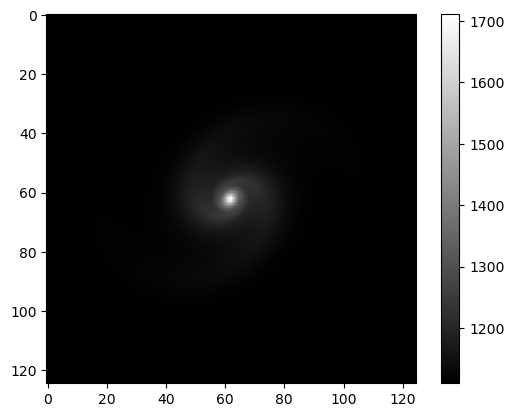

In [26]:
gname = "1237662224625369287"
with fits.open(pj(out_dir, gname, "no-fourier.fits")) as wf:
    without_fourier = wf[2].data
    
plt.imshow(without_fourier, cmap='gray')
plt.colorbar()

In [27]:
#ANALYTICAL APPROACH

In [28]:
def convert_to_cartesian(galaxy_info: dict) -> dict:
    points_dict = dict()
    
    for galaxy, values in galaxy_info.items():
        points_list = []
        
        for value in values:
            radius, theta = value
            points_list.append((radius*np.cos(theta), radius*np.sin(theta)))
        
        points_dict[galaxy] = points_list
        
    return points_dict

In [29]:
cart_coordinates = convert_to_cartesian(polar_coordinates)

In [30]:
def circle_tangent_slope(point: tuple) -> float:
    x, y = point
    return -(y/x)

def arm_tangent_slope(point: tuple, approx: tuple) -> float:
    x, y = point
    x_approx, y_approx = approx
    return (x-x_approx)/(y-y_approx)

def expected_pa_degrees(m1: float, m2: float) -> float:
    tan_theta = abs((m2 - m1)/(1 + m2*m1))
    return np.arctan2(tan_theta) * 180/np.pi

In [112]:
def find_expected_pa(point_dict: dict) -> dict:
    expected_pa_dict = dict()
    
    for galaxy, values in point_dict.items():
        pa_list = []
    
        for i in range(len(values)-1):
            m1 = circle_tangent_slope(values[i])
            m2 = arm_tangent_slope(values[i], values[i+1])
            pa_list.append(expected_pa_degrees(m1, m2))
        
        if pa_list:
            expected_pa_dict[galaxy] = pa_list
        
    return expected_pa_dict

In [113]:
def pa_residuals(original: dict, expected:dict) -> dict:
    pa_residual_dict = dict()
    
    for galaxy, values in expected.items():
        original_values = original[galaxy]
        pa_residual_list = [((original_values[i] - values[i])**2)/values[i] for i in range(len(values))]
        pa_residual_dict[galaxy] = pa_residual_list
    
    return pa_residual_dict

In [114]:
ana_pa = find_expected_pa(cart_coordinates)
good_residuals = pa_residuals(diff_pa, ana_pa)

def avg_pa(original, expected):
    avg_pa_dict = dict()
    
    for galaxy, value in original.items():
        avg_org = sum(value)/len(value)
        avg_ana = sum(expected[galaxy])/len(expected[galaxy])
        avg_pa_dict[galaxy] = (avg_org + avg_ana)/2
        
    return avg_pa_dict 

average_pa = avg_pa(diff_pa, ana_pa)

In [115]:
def avg_residuals(residual_dict: dict) -> dict:
    avg_residuals_dict = {}
    
    for galaxy, value in residual_dict.items():
        avg = sum(value)/len(value)
        avg_residuals_dict[galaxy] = avg
        
    return avg_residuals_dict

In [116]:
def get_sparcfire_pa(src_dir) -> dict:
    #src_dir = "/home/portmanm/run11_sparcfire_pa/sparcfire-out"
    spfire = dict()

    for gpath in glob.glob(pj(src_dir, "123*")):
        
        gname = os.path.basename(gpath)
        
        try:
            info = pd.read_csv(pj(gpath, f"{gname}.csv"))
            spfire[gname] = abs(info[' pa_alenWtd_avg_domChiralityOnly'][0])
            #print('done')
        
        except (AttributeError, FileNotFoundError, Exception):
            #print('enter catch')
            continue
            
    return spfire      

In [117]:
def plot_scatter(info: dict, differential: dict, analytical: dict, spfire: dict, output_dir: str, differential_2 = {}): #, step: float):
        
    for galaxy, an_pa_values in analytical.items():
        if galaxy in spfire:
            rad = info[galaxy]
            #1 less data point because calculating pa requires approx tangent line
            diff_pa_values = differential[galaxy][:-1]
                
            plt.figure()
            #plt.scatter(x=[rad[p][0] for p in range(len(rad)-1)], y=an_pa_values, color='red')
            plt.scatter(x=[rad[p][0] for p in range(len(rad)-1)], y=diff_pa_values, color='blue')
            
            if differential_2:
                diff2_pa_values = differential_2[galaxy][:-1]
                plt.scatter(x=[rad[p][0] for p in range(len(rad)-1)], y=diff2_pa_values, color='green')
                
            plt.axhline(spfire[galaxy], linewidth=2)
            

            plt.title(f'Galaxy {galaxy}')
            plt.xlabel(f'Radius') # (step {step})')
            plt.ylabel('Pitch Angle (degrees)')

            #plt.savefig(f'/home/portmanm/run10_testing_1000/sparcfire-out/scatter_plots/{galaxy}.png')
            plt.savefig(f'{pj(output_dir, galaxy)}.png')
            plt.close()
      
        else:
            print(f'{galaxy} info missing')
    

In [118]:
def plot_overlay(info: dict, differential: dict, analytical: dict, spfire: dict, output_dir: str):
    
    for galaxy, an_pa_values in analytical.items():
        if galaxy in spfire:
            rad = info[galaxy]
            #1 less data point because calculating pa requires approx tangent line
            diff_pa_values = differential[galaxy][:-1]
            plt.figure()
            
            folder = pj(out_dir, galaxy)
            image = pj(folder, f"{galaxy}-B_autoCrop.png")
            
            
            polar = polar_coordinates[galaxy]
      
            theta = [polar[p][1] for p in range(len(polar))]
            r = [polar[p][0] for p in range(len(polar))]

            fig = plt.gcf()
            
            fig.set_figwidth(4)
            fig.set_figheight(4)

            axes_coords = [0, 0, 1, 1]
            
            
            #polar plot
            ax_polar = fig.add_axes(axes_coords, projection = 'polar')
            #ax_polar.patch.set_alpha(0)
            #ax_polar.set_theta_zero_location("W")
            ax_polar.plot(theta, r, color='black', alpha=1,  linewidth=2)
            #ax_polar.plot(np.array(theta) - np.pi, r, color='black', alpha=1,  linewidth=2)
            #ax_polar.plot(np.array(theta), -r, color='black', alpha=1,  linewidth=2)
            #ax_polar.set_xlabel("radius")#[str(round(rad)) for i, rad in enumerate(r) if not i % 10])
            ax_polar.grid(False)
            ax_polar.set_xticklabels([])
            ax_polar.set_yticklabels([])
            #ax_polar.set_title(f'Galaxy {galaxy}', va = 'bottom')
            ax_polar.axis('off')
            
            #background image
            ax_image = fig.add_axes(axes_coords)
            model = pj(folder, f"{galaxy}_galfit_out.fits")

            test_model = OutputFits(model)
            
            row_max, col_max = np.unravel_index(test_model.model.data.argmax(), test_model.model.data.shape)
            max_arg = test_model.model.data[row_max][col_max]
            #print(max_arg)
            
            row_min, col_min = np.unravel_index(test_model.model.data.argmin(), test_model.model.data.shape)
            min_arg = test_model.model.data[row_min][col_min]
            #print(min_arg)
            
            #normalize pixels
            result = (test_model.model.data - min_arg)/(max_arg - min_arg)
            
                
            #ax_image.imshow(np.fliplr(result), interpolation='none', aspect='auto', cmap='gist_stern', alpha = 0.8)
            ax_image.axis('off')
                                    

            #plt.savefig(f'/home/portmanm/run10_testing_1000/sparcfire-out/overlay_plots/{galaxy}.png', bbox_inches="tight")
            plt.savefig(f'{pj(output_dir, galaxy)}.png', transparent = True)
            #plt.savefig(f'/home/portmanm/run11_sparcfire_pa/sparcfire-out/overlay_plots/{galaxy}.png', bbox_inches="tight")
            plt.close()
            
        else:
            print(f'{galaxy} info missing')
            

In [630]:
scatter_dir = pj(out_dir, "scatter_plots")
#overlay_dir = pj(out_dir, "overlay_plots")
if not exists(scatter_dir):
    os.mkdir(scatter_dir)
        
# if not exists(overlay_dir):
#     os.mkdir(overlay_dir)

In [119]:
plot_scatter(polar_coordinates, diff_pa, ana_pa, get_sparcfire_pa(out_dir), scatter_dir) #, step_size)
#plot_overlay(polar_coordinates, diff_pa, ana_pa, get_sparcfire_pa(out_dir), overlay_dir)